In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import multiprocessing
plt.style.use('dark_background')

In [2]:
filename = "../Domain/data/dataset.pkl"

In [3]:
with open(filename, "rb") as handle:
    # List all groups
    f = pickle.load(handle)
    features = f['features']
    labels   = f['labels']
    feat_names   = f['feat_names']

In [4]:
allowed_feat = {'Confirmados Comuna': True, 
                'Confirmados Comuna Acumulados': True,
                'Confirmados Region Acumulados': False, 
                'Nacional nuevos con sintomas': True,
                'Nacional totales': True, 
                'Nacional recuperados': True, 
                'Nacional Fallecidos': True,
                'Nacional activos': True, 
                'Nacional nuevos sin sintomas': True,
                'Nacional nuevos totales': True, 
                'Nacional activos por FD': True,
                'Nacional activos por FIS': True, 
                'Nacional recuperados por FIS': True,
                'Nacional recuperados por FD': True, 
                'Nacional confirmados recuperados': True,
                'Nacional activos confirmados': True, 
                'Nacional probables acumulados': True,
                'Nacional activos probables': True, 
                'Nacional nuevos sin notificar': True,
                'Nacional activos confirmados 2': False, 
                '# PCR Region': False, 
                '# UCI Region': False,
                'UCI Nacional <=39': True, 
                'UCI Nacional 40-49': True, 
                'UCI Nacional 50-59': True,
                'UCI Nacional 60-69': True, 
                'UCI Nacional >=70': True,
                'Fallecidos Nacional <=39': True, 
                'Fallecidos Nacional 40-49': True,
                'Fallecidos Nacional 50-59': True, 
                'Fallecidos Nacional 60-69': True,
                'Fallecidos Nacional 70-79': True, 
                'Fallecidos Nacional 80-89': True,
                'Fallecidos Nacional >=90': True, 
                'Casos Nuevos Reg Cum': False,
                'Fallecidos Region Cum': False}

In [5]:
mask = np.array(list(allowed_feat.values()))
x_feat = features[:, mask]
feat_names = np.array(feat_names)[mask]

In [6]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([27521,  8123]))

In [7]:
x_feat = np.where(x_feat<=0, -99, x_feat)

In [8]:
missing = np.sum(np.where(x_feat == -99, 1, 0))
valid   = np.sum(np.where(x_feat != -99, 1, 0))

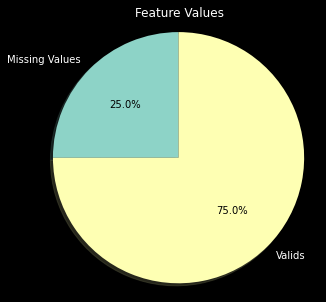

In [9]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels_tag = 'Missing Values', 'Valids'
sizes = [missing, valid]

fig1, ax1 = plt.subplots(figsize=(5,5))
_, _, autotexts = ax1.pie(sizes, labels=labels_tag, autopct='%1.1f%%',
        shadow=True, startangle=90)


for autotext in autotexts:
    autotext.set_color('Black')
    
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Feature Values')
plt.show()

In [10]:
%%time
parameters = {"n_estimators": [1000], 
              "max_depth": [None], 
              "class_weight":["balanced_subsample"],
              "n_jobs":[multiprocessing.cpu_count()]}

clf = GridSearchCV(RandomForestClassifier(), parameters, cv=3)
clf.fit(x_feat, labels)

CPU times: user 4min 32s, sys: 1.98 s, total: 4min 34s
Wall time: 1min 49s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced_subsample'],
                         'max_depth': [None], 'n_estimators': [1000],
                         'n_jobs': [8]})

In [11]:
print('CV ACC: {:.2f} +- {:.2f}'.format(clf.cv_results_['mean_test_score'][0], 
                                        clf.cv_results_['std_test_score'][0]))

CV ACC: 0.73 +- 0.03


In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_feat, labels, test_size=0.33, random_state=42)

In [24]:
model = RandomForestClassifier(n_estimators=clf.best_estimator_.n_estimators, 
                               max_depth=None, 
                               class_weight='balanced_subsample', 
                               n_jobs=multiprocessing.cpu_count())
model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000,
                       n_jobs=8)

In [25]:
y_pred = model.predict(x_test)

In [26]:
precision, recall, f1, supp = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Precision:{:.2f}\nRecall:{:.2f}\nF1:{:.2f}'.format(precision, recall, f1))

Precision:0.79
Recall:0.75
F1:0.77


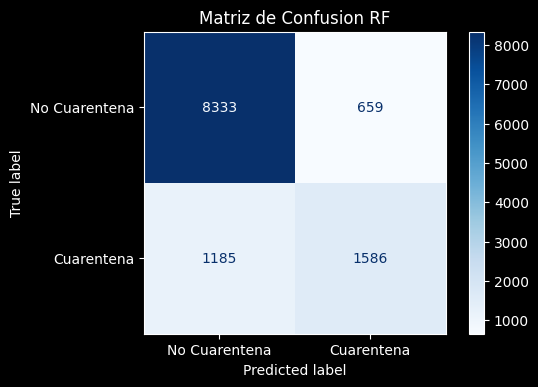

In [27]:
fig, ax = plt.subplots(1,1, dpi=100)
disp = plot_confusion_matrix(model, x_test, y_test,
                             display_labels=['No Cuarentena', 'Cuarentena'],
                             cmap=plt.cm.Blues,
                             normalize=None, ax=ax)
ax.set_title('Matriz de Confusion RF')
fig.savefig('./cm.png', format='png')

In [28]:
len(model.feature_importances_)

30

In [29]:
sorted_indices = np.argsort(model.feature_importances_, )

importances   = model.feature_importances_[sorted_indices][::-1]
feature_names = np.array(feat_names)[sorted_indices][::-1]

In [39]:
feature_names_bold = [r'$\bf{'+x+'}$' if 'Comuna' in x else x for x in feature_names]

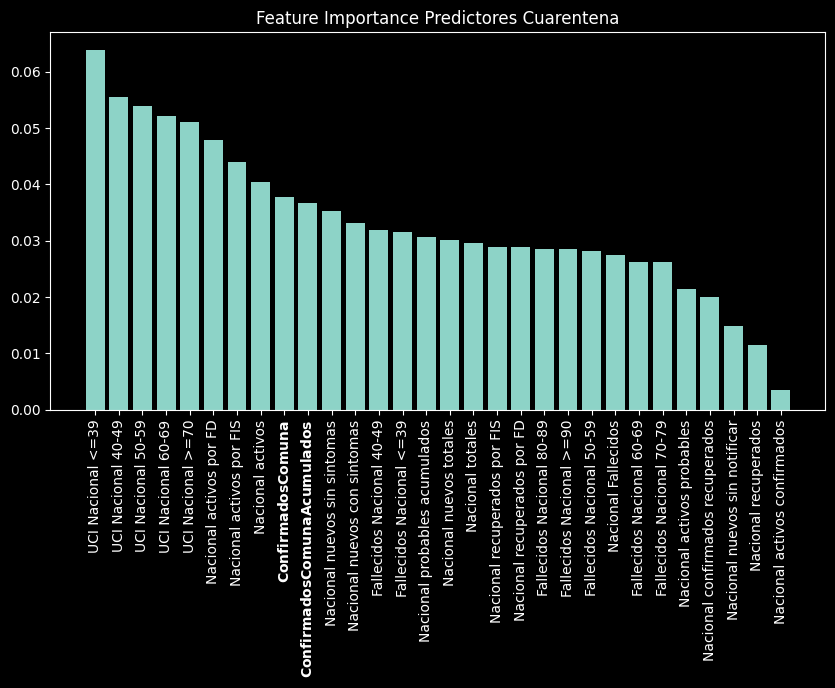

In [40]:
plt.figure(figsize=(10,5), dpi=100)
plt.bar(range(0, len(importances)), importances, align='center')
plt.xticks(range(0, len(importances)), feature_names_bold, rotation=90)
plt.title('Feature Importance Predictores Cuarentena')
plt.savefig('./importance.png', format='png', bbox_inches='tight')
plt.show()